# Практическая работа №8
Сверточная нейронная сеть <br>
Лебедев С.Д. - ИКБО-04-19

# Используемые библиотеки

In [ ]:
import torch
import torchvision
from torch import nn, optim, flatten
import torch.nn.functional as F

from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms

import numpy as np
import matplotlib.pyplot as plt

import random

# Модель сверточной нейронной сети

In [ ]:
class ConvolutionalNeuralNetwork(nn.Module):                                    # Класс ConvolutionalNeuralNetwork модели сверточной нейронной сети
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(                                            # Первый слой
            nn.Conv2d(1, 16, kernel_size=5, padding=2),                         # Применение 2D свертки ко входному сигналу (на входе размерность 1, на выходе размерность 16)
            nn.Dropout2d(p = 0.2),                                              # Обнуляются случайные 20% (p = 0.2) входных тензоров для борбы с переобучением
            nn.BatchNorm2d(16),                                                 # Применяется нормализация для батча размерности 16
            nn.ReLU(),                                                          # Функция активации - ReLU
            nn.MaxPool2d(2)                                                     # Применение операции двумерного максимизирующего пулинга, kernel_size = 2
        )
            
        self.layer2 = nn.Sequential(                                            # Второй слой
            nn.Conv2d(16, 32, kernel_size=5, padding=2),                        # Применение 2D свертки ко входному сигналу (на входе размерность 16, на выходе размерность 32)
            nn.Dropout2d(p = 0.2),                                              # Обнуляются случайные 20% (p = 0.2) входных тензоров для борбы с переобучением                                           
            nn.BatchNorm2d(32),                                                 # Применяется нормализация для батча размерности 32
            nn.ReLU(),                                                          # Функция активации - ReLU
            nn.MaxPool2d(2)                                                     # Применение операции двумерного максимизирующего пулинга, kernel_size = 2
        )
            
        self.layer3 = nn.Sequential(                                            # Третий слой
            nn.Linear(7*7*32, 120),                                             # Применение линейного преобразования (на входе размерность 7*7*32, на выходе размерность 120) (7*7*32 - размер сверток на их количество)
            nn.Dropout(p = 0.4),                                                # Обнуляются случайные 40% (p = 0.4) входных тензоров для борбы с переобучением    
            nn.Linear(120, 10)                                                  # Применение линейного преобразования (на входе размерность 120, на выходе размерность 10 - на каждый из классов)
        )
    
    def forward(self, x):                                                       # Прямое прохождение
        out = self.layer1(x)                                                    # Выход 1го слоя
        out = self.layer2(out)                                                  # Выход 2го слоя
        out = out.view(out.size(0), -1)                                         # Все свёртки складываются в один вектор перед подачей в линейный слой
        out = self.layer3(out)                                                  # Выход 3го слоя
        return out

model = ConvolutionalNeuralNetwork()
print(model)

ConvolutionalNeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=1568, out_features=120, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): Linear(in_features=120, out_features=10, bias=True)
  )
)


In [ ]:
transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,), )])                   # Трансформер для последовательно применяемых трансформаций входных данных (применяется для каждого элемента датасета)

train_dataset = FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train = True, transform=transformer)         # Загрузка датасета Fashion MNIST, тренировочная выборка
test_dataset = FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train = False, transform=transformer)         # Загрузка датасета Fashion MNIST, тестовая выборка

В тренировочной выборке 60000 изображений
В тестовой выборке 10000 изображений


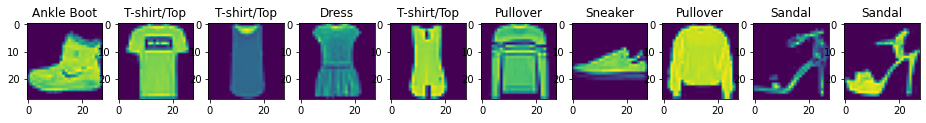

In [ ]:
output_decoding = {                         # Словарь соответствия индекса значению (взят с kaggle для этого датасета)
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

amount = 10                                 # Просто отрисовка первых 10 изображений из датасета с соответствующими классами
imgs = iter(train_dataset)
fig, axs = plt.subplots(1, amount, figsize = (16, 16))
for i in range(amount):
    image, label = next(imgs)
    axs[i].imshow(image.squeeze())
    axs[i].set_title(output_decoding[label])

print(f'В тренировочной выборке {len(train_dataset)} изображений')
print(f'В тестовой выборке {len(test_dataset)} изображений')

# Параметры обучения нейронной сети


*   **batch_size** - число тренировочных объектов, подаваемых на вход за одну итерацию обучения
*   **epochs** - количество эпох обучения
*   **lr** - коэффициент скорости обучения
*   **opt** - оптимизатор
*   **loss_func** - функция потерь

In [ ]:
batch_size = 64                                 # Можно поменять
epochs = 10                                     # Можно еще увеличить
lr = 0.001                                      # Тоже пробовал разные, но такой lr показался оптимальным

opt = optim.Adam(model.parameters(), lr=lr)     # Используется оптимизатор Adam, он тут лучше работает чем SGD
loss_func = nn.CrossEntropyLoss()               # Функция потерь - Cross Entropy (формула ниже)


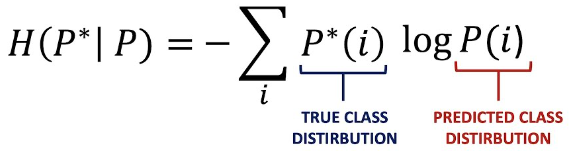

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,               # DataLoader для тренировочной выборки
                                          batch_size=batch_size,                #
                                          shuffle=True)                         # Изображения будут перемешиваться

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,                 # DataLoader для тестовой выборки
                                          batch_size=batch_size)                #

# Обучение нейронной сети

In [ ]:
train_avg_loss = []                                                             # Список для ошибок после каждой эпохи обучения

model.train()                                                                   # Переключение в режим обучения

for e in range(epochs):

    train_loss = 0                                                              # Ошибка на эпохе обучения
    for X, Y in train_loader:
        prediction = model(X)                                                   # Предсказание для текущего входного значеиня
        loss = loss_func(prediction, Y)                                         # Определение ошибки в соответствии с функцией потерь
        train_loss += loss

        opt.zero_grad()                                                         # Обнуление градиента
        loss.backward()                                                         # Обратное распространение ошибки
        opt.step()                                                              # Выполнение шага оптимизации
        
    train_avg_loss.append(train_loss / len(train_loader))                       # Запись средней ошибки на текущей эпохе обучения
    print(f'Epoch: {e+1}/{epochs}, Loss: {train_avg_loss[-1]}')

Epoch: 1/10, Loss: 0.5039904713630676
Epoch: 2/10, Loss: 0.3630020320415497
Epoch: 3/10, Loss: 0.3297092020511627
Epoch: 4/10, Loss: 0.3049201965332031
Epoch: 5/10, Loss: 0.29075390100479126
Epoch: 6/10, Loss: 0.27983561158180237
Epoch: 7/10, Loss: 0.26851192116737366
Epoch: 8/10, Loss: 0.2631421685218811
Epoch: 9/10, Loss: 0.25280293822288513
Epoch: 10/10, Loss: 0.2501072287559509


# Проверка обученной модели

In [ ]:
model.eval()            # Переключение в режим оценивания модели


Можно запускать ячейку много раз подряд через Ctrl + Enter. Модель тестируется на случайных изображениях из обучающей выборки.

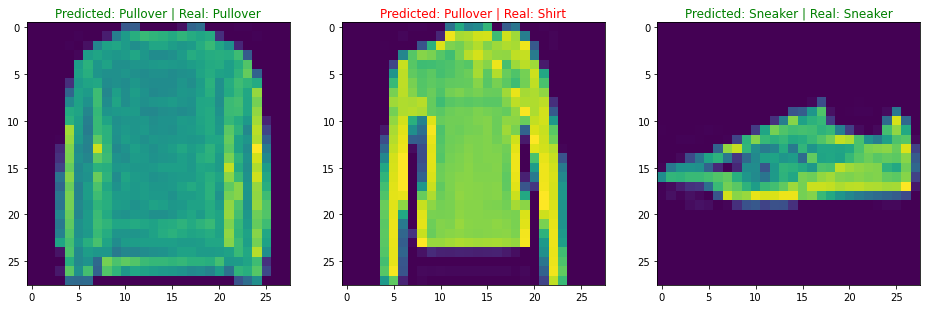

In [ ]:
test_amount = 3                                                                         # Количество случайно выбираемых из тестовой выборки изображений

random_indexes = random.sample(range(0, len(test_dataset)), test_amount)                # Генерируются случайные индексы
random_images = [test_dataset[i] for i in random_indexes]                               # Выбираются случайные изображения

fig, axs = plt.subplots(1, test_amount, figsize = (16, 16))
for i in range(test_amount):
    random_image = random_images[i][0]
    with torch.no_grad():
        prediction = torch.max(model(random_image[None]),1)[1]                          # Определение предсказания для изображения
    
    predicted_label = output_decoding[prediction.item()]                                # Предсказанный label
    real_label = output_decoding[random_images[i][1]]                                   # Реальный label

    title = f"Predicted: {predicted_label} | Real: {real_label}"
    matches = (predicted_label == real_label)

    axs[i].imshow(random_image.squeeze())
    axs[i].set_title(title, color='green' if matches else 'red')                        # Если label'ы совпадают - подпись к картинке зеленая, иначе - красная